In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os


from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Convolution2D, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, AveragePooling2D, UpSampling2D, Activation, Flatten, Add, ReLU
from tensorflow.keras import layers

In [37]:
# para que tf no use mucha vram

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## Read dataset

In [38]:
IMAGE_SIZE = 512
BATCH_SIZE = 32
SEED = 0

In [39]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
output_shape = IMAGE_SIZE * IMAGE_SIZE * 3

In [56]:
from glob import glob
from os import listdir

def make_dataset(path, batch_size, img_size, seed=None):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        #image = tf.image.rgb_to_grayscale(image)
        #image = tf.image.grayscale_to_rgb(image)
        image = tf.image.resize(image, [img_size, img_size])

        image = tf.cast(image, tf.float32)
        image = image / 255

        return image
    
    def parse_mask(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_png(image, channels=1)
        #image = tf.image.rgb_to_grayscale(image)
        #image = tf.image.grayscale_to_rgb(image)
        image = tf.image.resize(image, [img_size, img_size])

        image = tf.cast(image, tf.float32)
        #image = tf.reshape(image, [img_size * img_size * 1])

        return image

    def configure_for_performance(ds):
        # Shuffle dataset every time, even if its divided by years
        ds = ds.shuffle(buffer_size=100)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        #ds = ds.prefetch(buffer_size=10)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        return ds

    path_image = "/images"
    path_mask = "/masks"

    filenames_image = [str(i) for i in listdir(path + path_image)]
    filenames_mask = [str(i) for i in listdir(path + path_mask)]

    filenames_image.sort()
    filenames_mask.sort()

    #print(filenames_image)
    #print(filenames_mask)

    filenames_image_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(filenames_image, dtype=tf.string))
    filenames_mask_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(filenames_mask, dtype=tf.string))

    #print(filenames_image_ds)

    images_ds = filenames_image_ds.map(lambda x: parse_image(x), num_parallel_calls=8)
    masks_ds = filenames_mask_ds.map(lambda x: parse_mask(x), num_parallel_calls=8)

    # create tensorflow dataset of images and values (train, val, test)
    images_masks_ds = tf.data.Dataset.zip((images_ds, masks_ds))
    images_masks_ds = configure_for_performance(images_masks_ds)

    return images_masks_ds, len(filenames_image), len(filenames_mask)

In [57]:
train_path = 'dataset/dataset_v2/train'
val_path = 'dataset/dataset_v2/validation'
test_path = 'dataset/dataset_v2/test'

In [58]:
train_ds, len_train_image, len_train_mask = make_dataset(train_path, BATCH_SIZE, IMAGE_SIZE, 0)
val_ds, len_val_image, len_val_mask = make_dataset(val_path, BATCH_SIZE, IMAGE_SIZE, 0)
test_ds, len_test_image, len_test_mask = make_dataset(test_path, BATCH_SIZE, IMAGE_SIZE, 0)

In [59]:
print(len_train_image, len_train_mask)
print(len_val_image, len_val_mask)
print(len_test_image, len_test_mask)

4152 4152
228 228
1406 1406


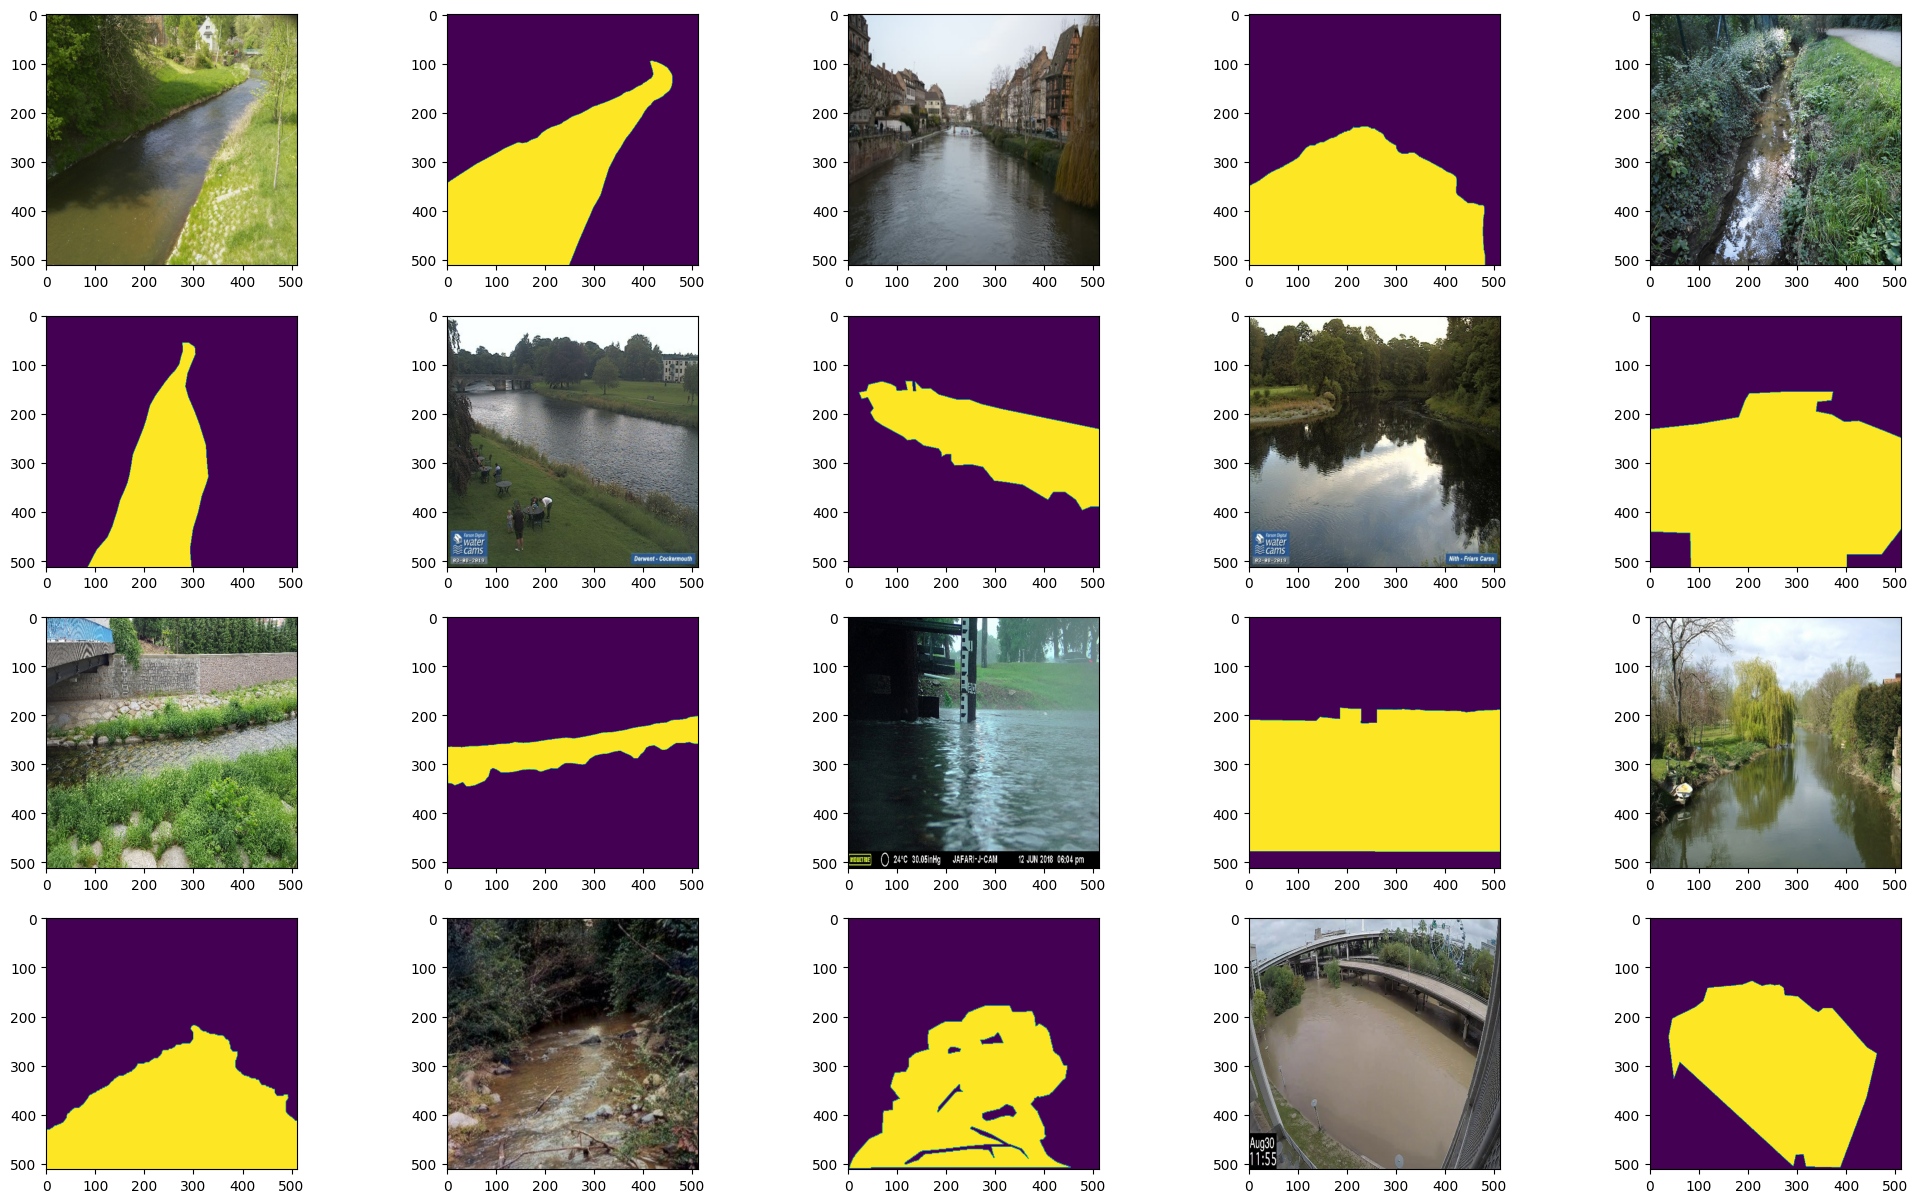

In [34]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 15))

for image, mask in val_ds.take(1):
    images = image[:10]
    masks = mask[:10]
    images_and_masks = []

    for i, j in zip(images, masks):
        images_and_masks.append(i)
        images_and_masks.append(j)

    for img_mask, ax in zip(images_and_masks, ax.flatten()):
        img_mask = img_mask.numpy()
        ax.imshow(img_mask)
    
    
plt.show()


## Create Model

### PSPNet

In [9]:
def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X
    
    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X
    # block_a
    X = Convolution2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = Convolution2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
                      padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = Convolution2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Convolution2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps 
    
    # block_1
    """base = conv_block(input_layer,[32,32,64],'1')
    # block_2
    base = conv_block(base,[64,64,128],'2')
    # block_3
    base = conv_block(base,[64,64,256],'3')
    # block_4
    base = conv_block(base,[64,64,512],'4')"""

    base = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    )
    
    for layer in base.layers:
        layer.trainable = False

    base = base(input_layer)

    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red = GlobalAveragePooling2D(name='red_pool')(base)
    red = tf.keras.layers.Reshape((1,1,512))(red)
    red = Convolution2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=512,interpolation='bilinear',name='red_upsampling')(red)
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Convolution2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Convolution2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Convolution2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)

    # base + red + yellow + blue + green
    return tf.keras.layers.concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    X = Convolution2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    X = Activation('sigmoid', name='last_conv_relu')(X)
    X = Flatten(name='last_conv_flatten')(X)
    return X

### U-Net model

In [10]:
def get_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=(img_size, img_size) + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 6, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)
    #outputs = layers.Flatten()(outputs)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

In [11]:
#input_layer = tf.keras.Input(shape=input_shape, name='input')
model = get_model(IMAGE_SIZE, 1)
#model = tf.keras.Model(inputs=input_layer,outputs=output_layer)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  3488        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

## Train model

In [13]:
import datetime

date_actual = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + date_actual
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_weights/{date_actual}_segmentation_best_weights.hdf5",
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)

In [14]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=60, batch_size=32, steps_per_epoch=np.ceil(len_train / BATCH_SIZE), validation_steps=np.ceil(len_val / BATCH_SIZE), callbacks=[tensorboard_callback, es_callback, checkpoint_callback])

Epoch 1/60


2022-11-08 14:50:41.053826: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-08 14:50:41.467411: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-08 14:50:41.468092: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-08 14:50:41.468104: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-08 14:50:41.469018: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-08 14:50:41.469076: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-08 14:50:42.078369: W tensorflow/core/common_runtime/bf

ResourceExhaustedError: Graph execution error:

Detected at node 'model/up_sampling2d_5/resize/ResizeNearestNeighbor' defined at (most recent call last):
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/traitlets/config/application.py", line 978, in launch_instance
      app.start()
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_61978/2510138604.py", line 4, in <module>
      model.fit(train_ds, validation_data=val_ds, epochs=60, batch_size=32, steps_per_epoch=np.ceil(len_train / BATCH_SIZE), validation_steps=np.ceil(len_val / BATCH_SIZE), callbacks=[tensorboard_callback, es_callback, checkpoint_callback])
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/layers/reshaping/up_sampling2d.py", line 146, in call
      return backend.resize_images(
    File "/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/backend.py", line 3693, in resize_images
      x = tf.image.resize(x, new_shape, method=interpolations[interpolation])
Node: 'model/up_sampling2d_5/resize/ResizeNearestNeighbor'
OOM when allocating tensor with shape[32,160,160,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/up_sampling2d_5/resize/ResizeNearestNeighbor}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5835]

In [ ]:
print(date_actual)

20221108-144744


In [ ]:
best_model = tf.keras.models.load_model(f'model_weights/{date_actual}_segmentation_best_weights.hdf5')

In [ ]:
def evaluate_model(model, test_values, steps):
  score = model.evaluate(test_values, steps=steps)
  return score

In [ ]:
test_loss, test_accuracy = evaluate_model(best_model, test_ds, steps=np.ceil(len_test / BATCH_SIZE))

4/4 [==============================] - 1s 173ms/step - loss: 47.2374 - accuracy: 0.0000e+00


1/1 [==============================] - 0s 332ms/step


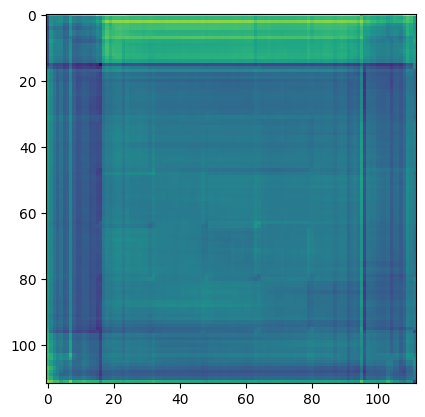

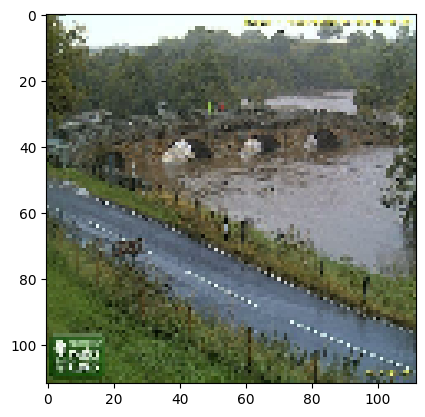

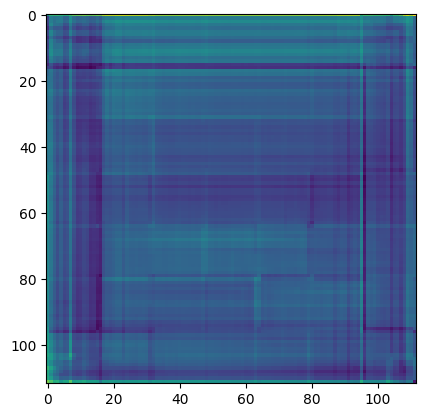

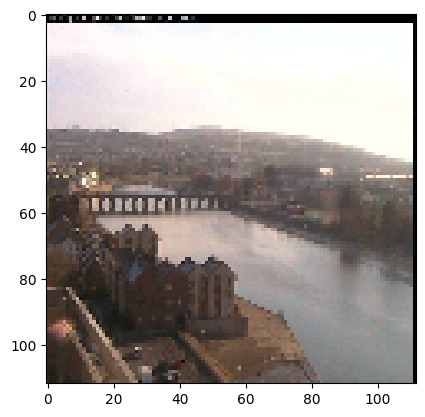

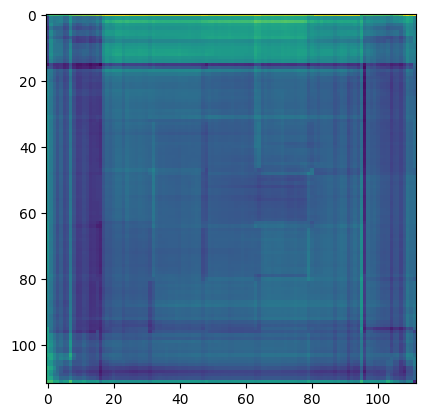

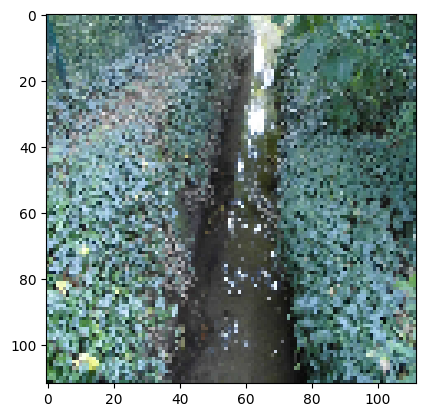

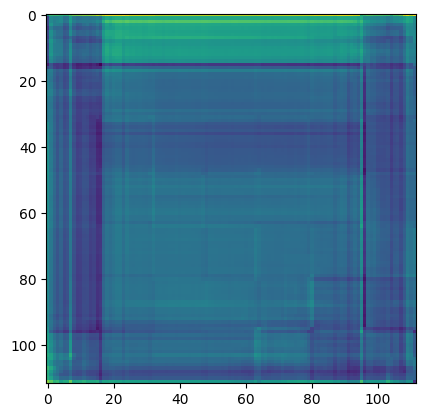

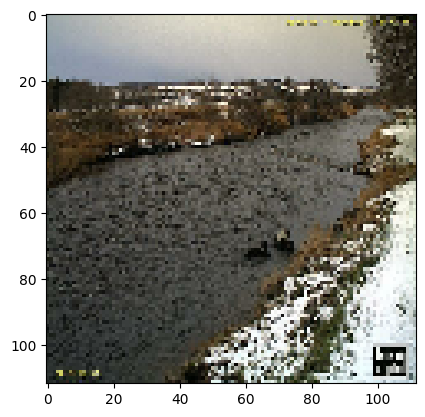

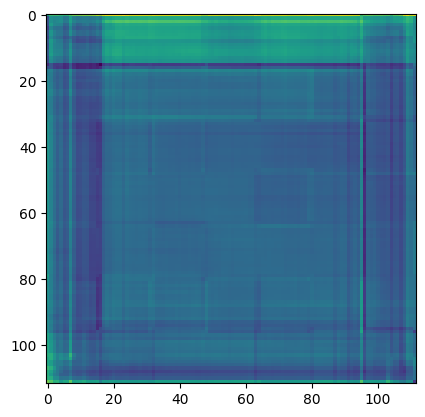

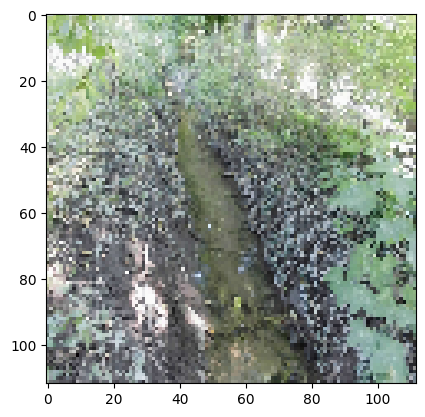

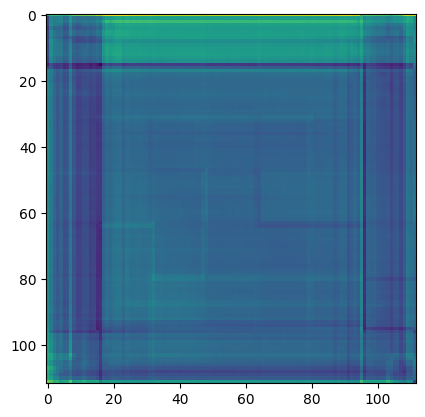

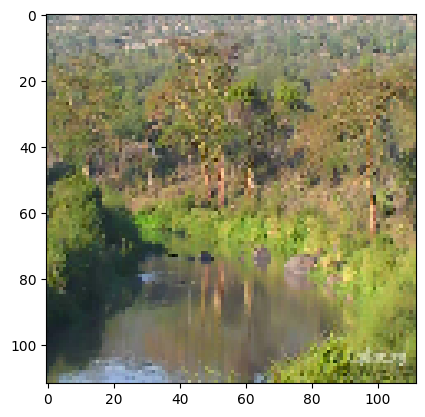

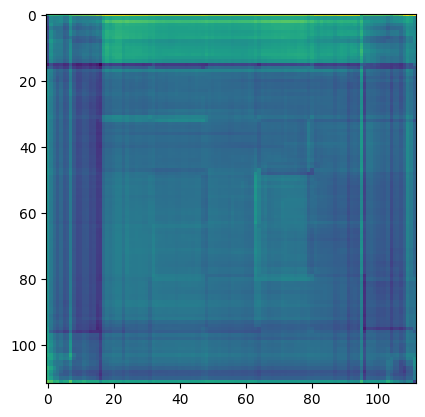

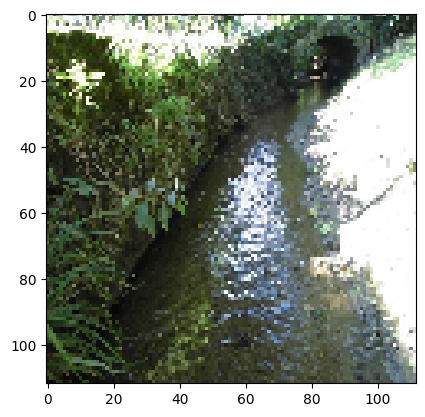

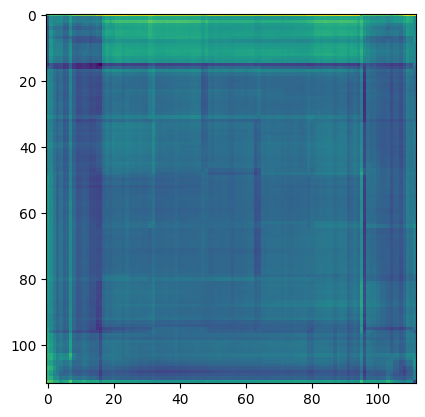

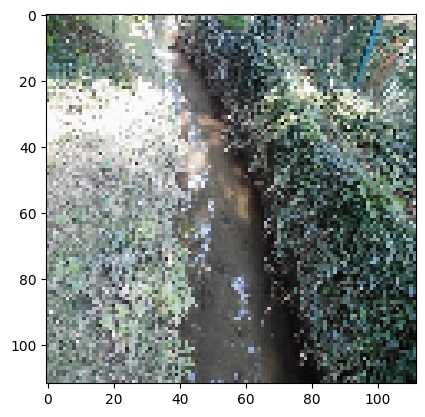

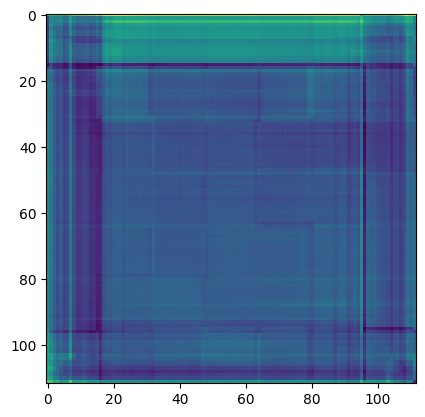

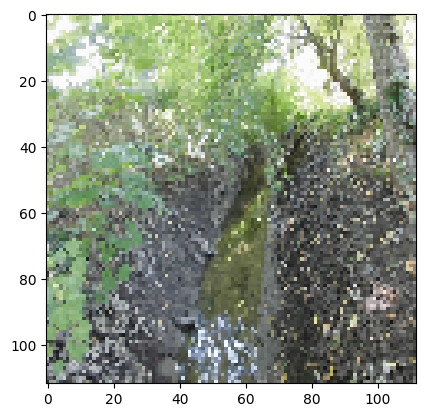

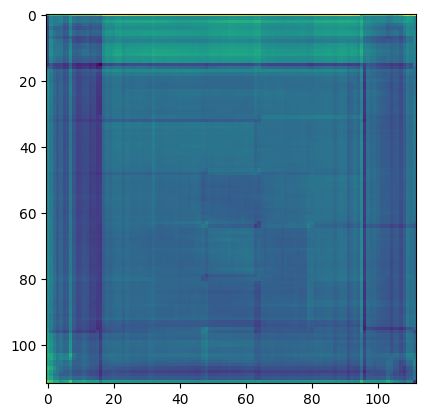

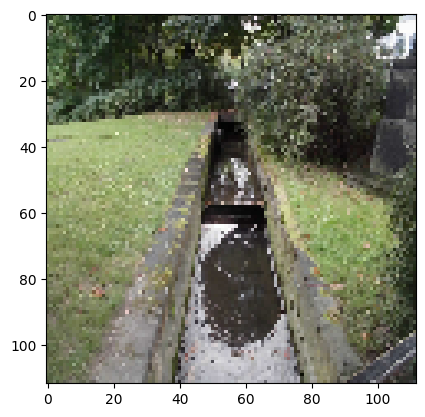

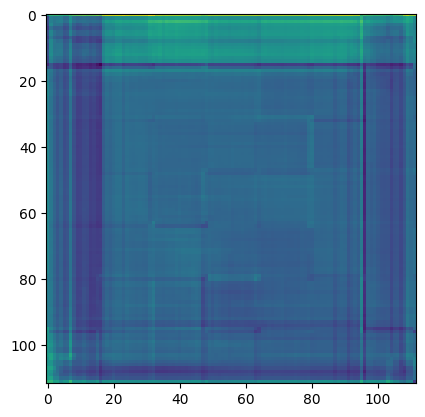

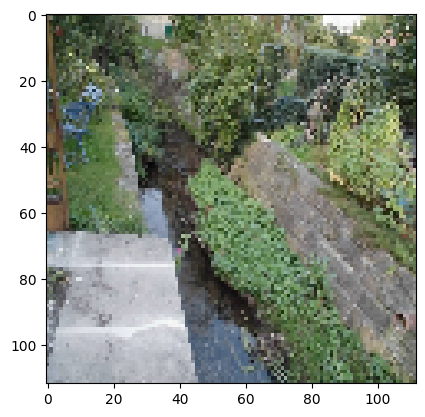

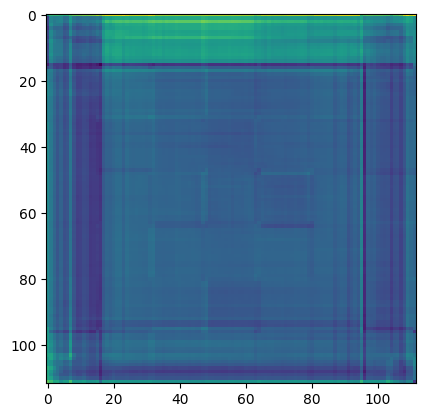

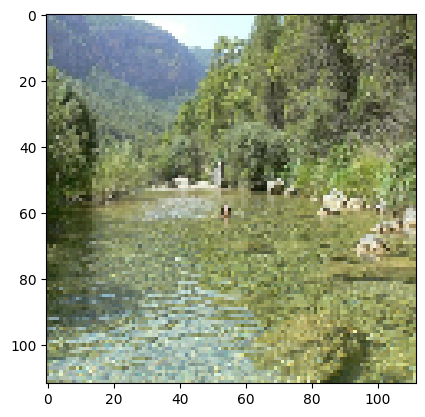

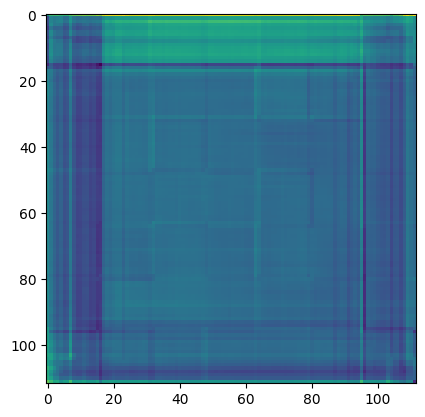

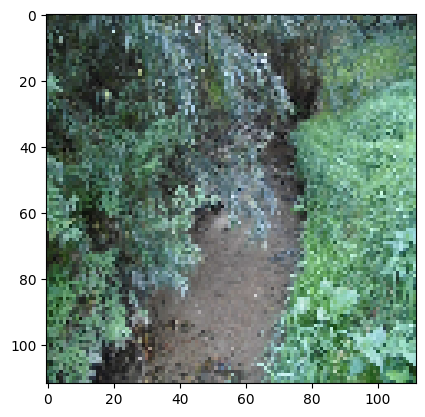

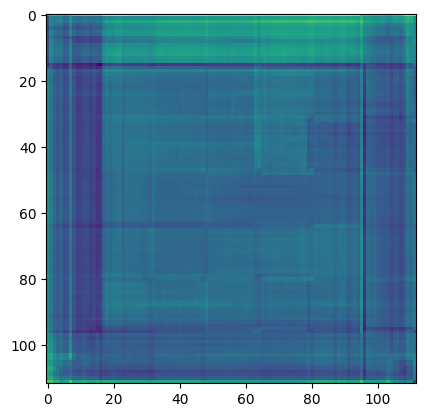

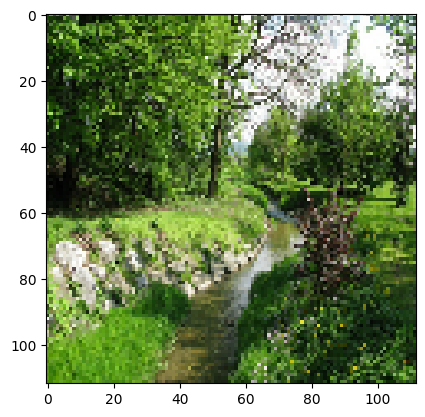

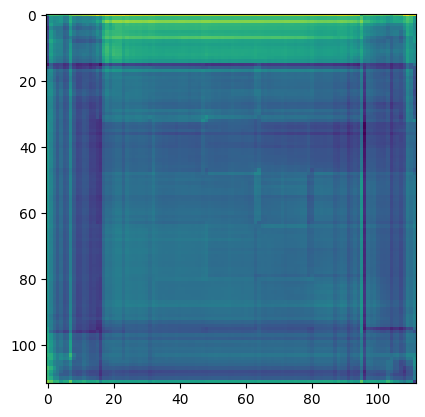

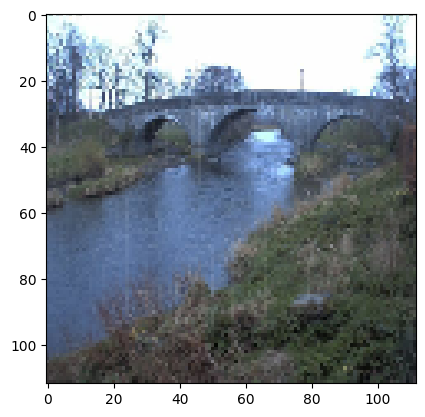

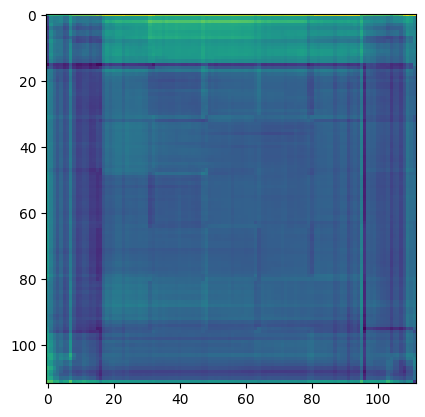

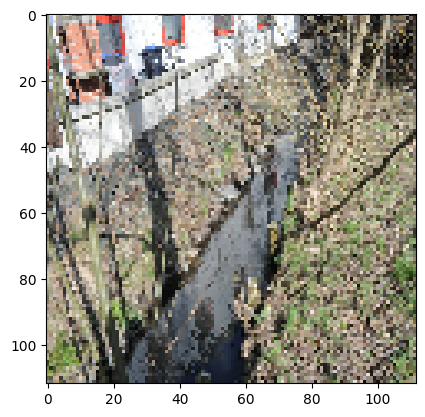

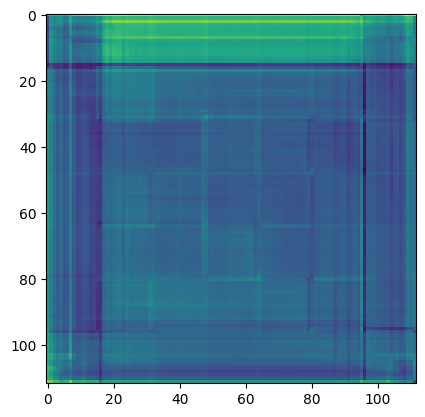

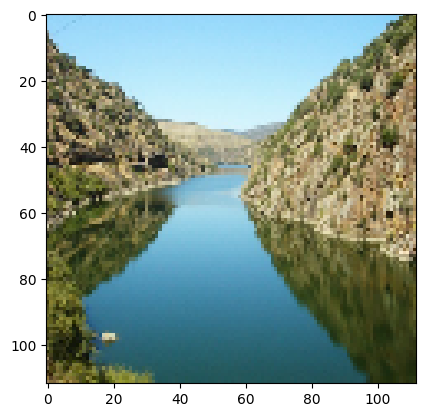

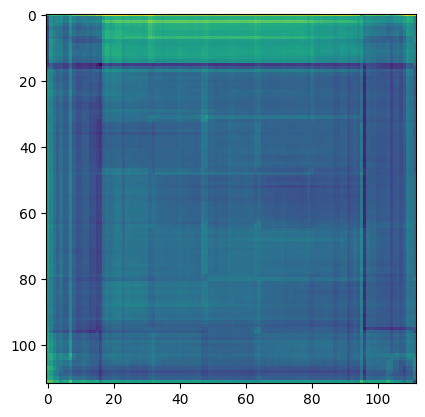

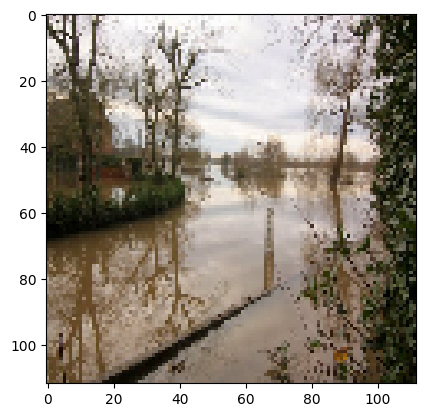

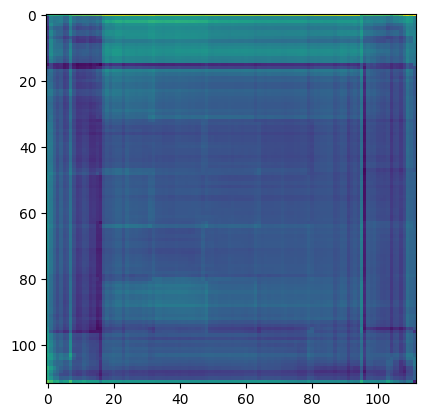

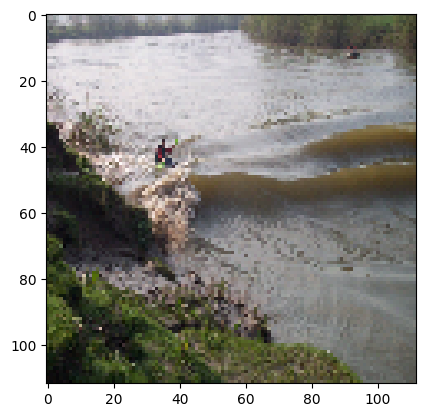

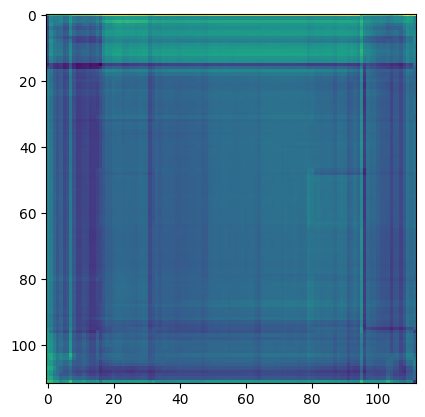

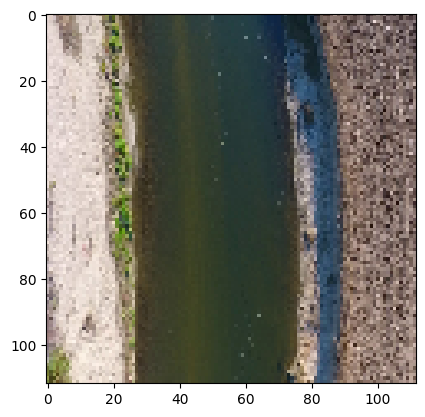

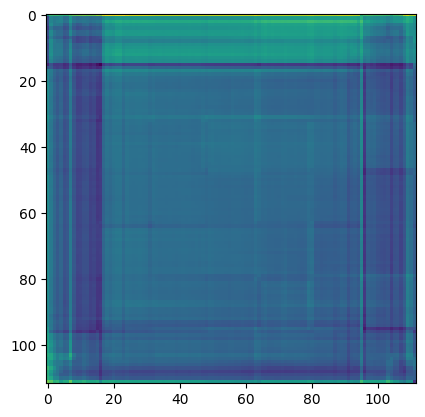

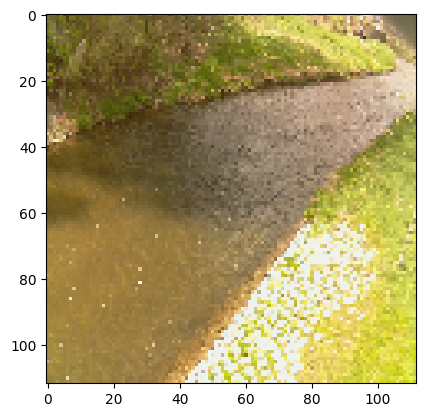

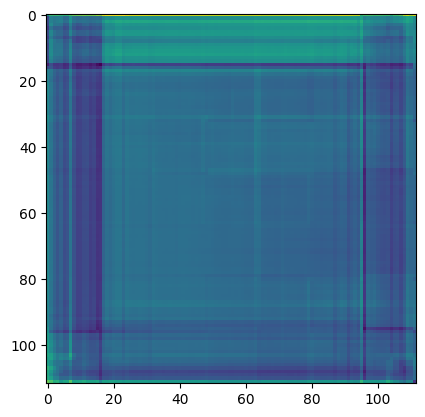

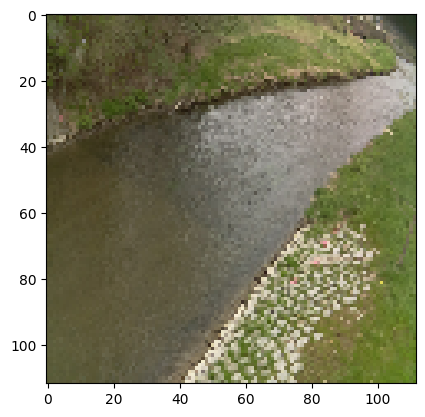

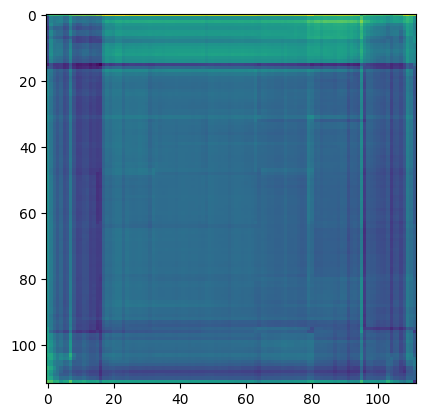

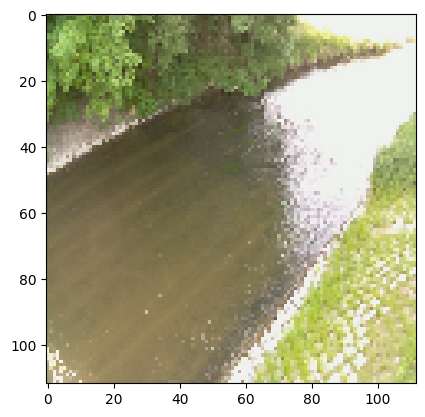

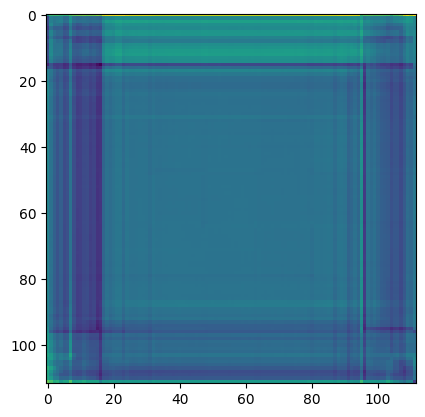

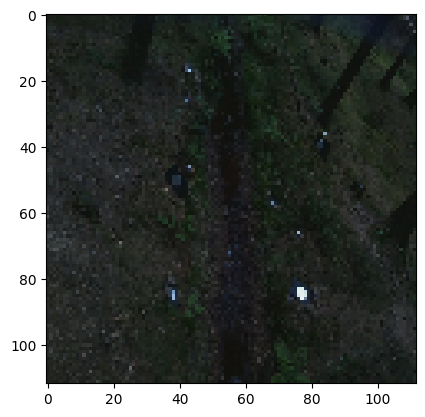

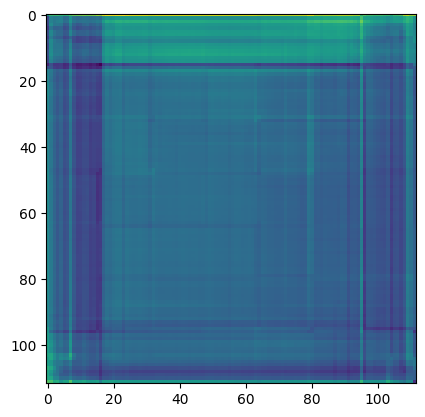

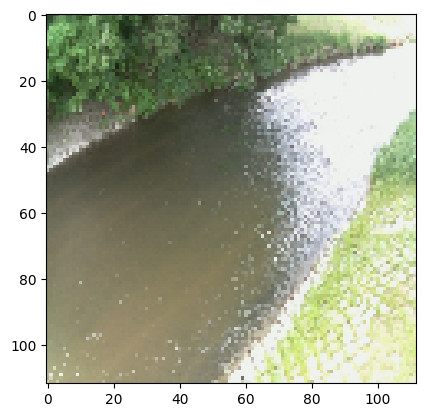

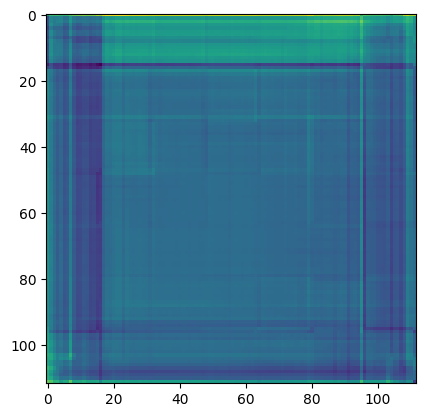

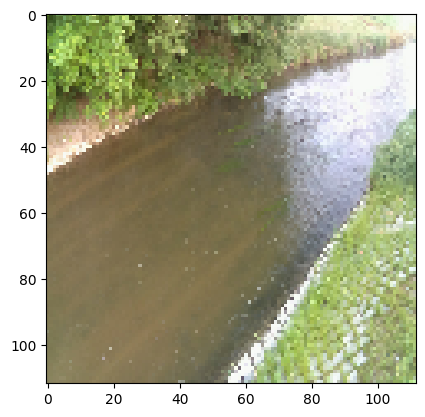

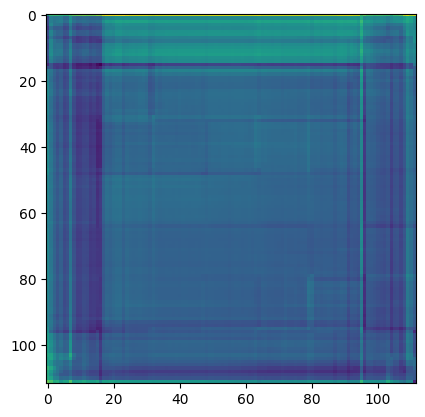

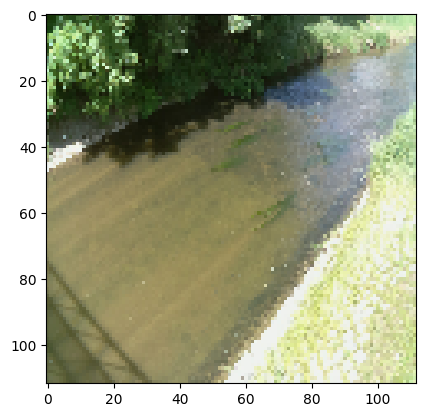

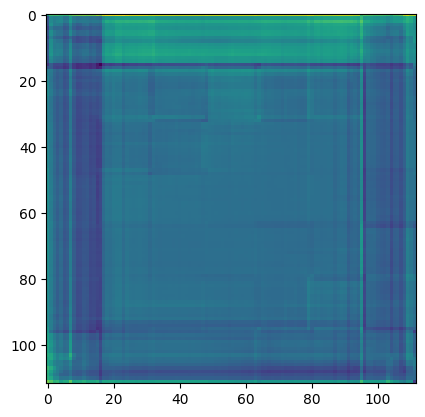

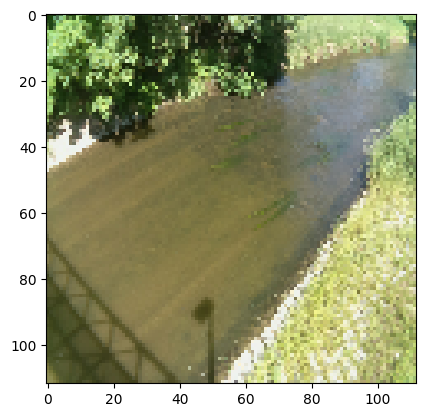

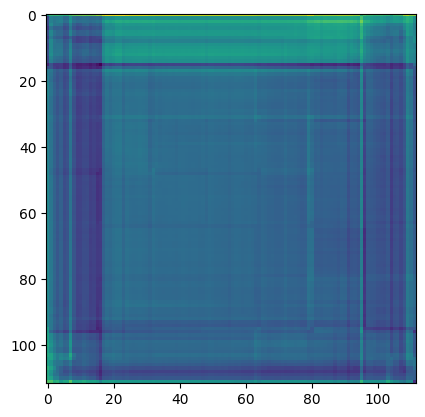

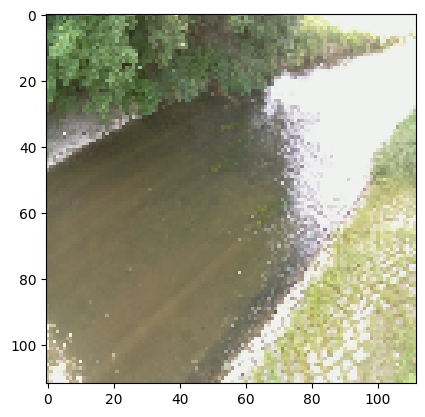

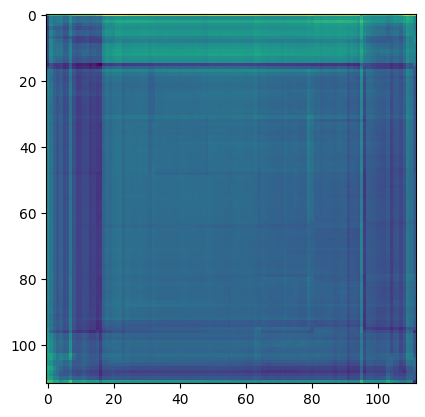

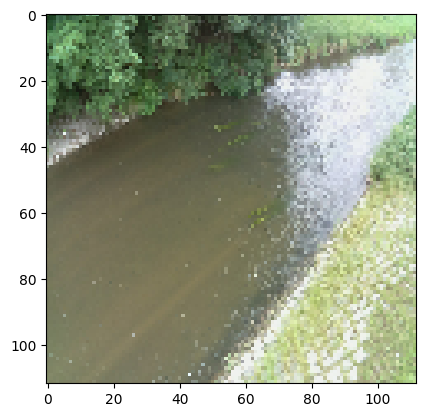

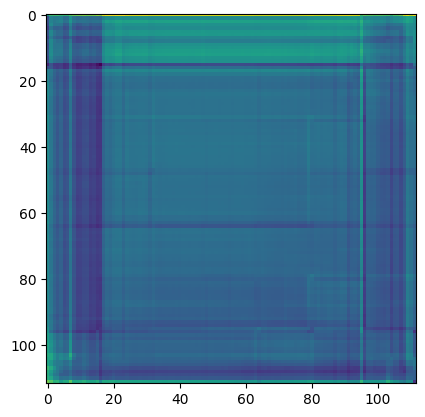

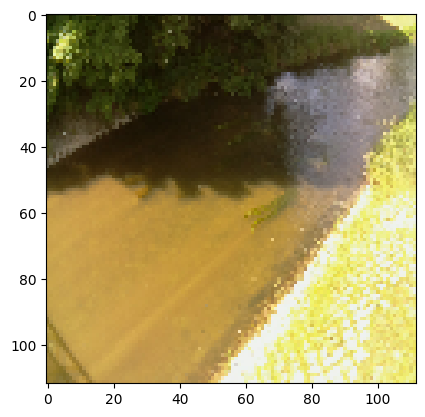

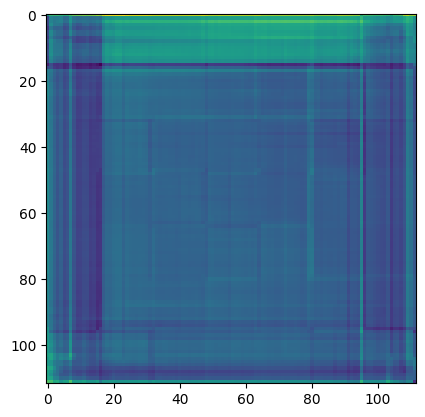

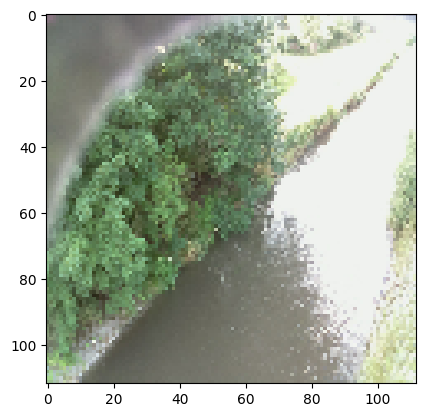

In [ ]:
for image, mask in test_ds.take(1):
    predictions = best_model.predict(x=image)
    
    for i, j in zip(predictions, image):
        j = j.numpy()
        i = np.reshape(i, (IMAGE_SIZE, IMAGE_SIZE, 1))
        
        plt.imshow(i)
        plt.show()
        plt.imshow(j)
        plt.show()
    
    plt.show()